In [ ]:
!pip install rasterio
!pip install geopandas
!pip install skimage

     |████████████████████████████████| 18.1MB 1.3MB/s 
     |████████████████████████████████| 972kB 4.5MB/s 
     |████████████████████████████████| 14.8MB 313kB/s 
     |████████████████████████████████| 10.9MB 151kB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import random
import cv2
from skimage import exposure
import rasterio
from rasterio.windows import Window
from rasterio import plot
from datetime import date
import pandas as pd
import geopandas as gpd
from random import shuffle
from statistics import mean 
import torch
import torchvision
from torchsummary import summary
from torch.utils.data import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import os
import re
import segmentation_models_pytorch as smp

In [ ]:
input_dir = "./drive/My Drive/Datasets/Project/pngCroppedImages/"
target_dir = "./drive/My Drive/Datasets/Project/pngGroundTruth/"
img_size = (224, 224)
num_classes = 2
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of samples:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 240
Number of samples: 240
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_0_4.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_0_4.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_0_5.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_0_5.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_1_10.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_1_10.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_1_8.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_1_8.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_2_0.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_2_0.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_2_1.png | ./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_2_1.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_2_10.png | ./

In [ ]:
# for input_path, target_path in zip(input_img_paths, target_img_paths):
#   mask = Image.open(target_path)
#   if len(np.unique(mask)) == 1:
#     print(target_path)

In [ ]:
class SlumDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        # resize = transforms.Resize(size=(256, 256))
        # image = resize(image)
        # mask = resize(mask)

        
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index])
        # img = img.read()
        img = np.transpose(img,(1,0,2))
        # x = x.astype(np.int16)  
        # x = torch.from_numpy(x)
        mask = Image.open(self.target_paths[index])
        # mask = mask.read(1)//65535
        # inv = np.logical_not(mask).astype(np.int16)
        # y = np.stack((mask,inv),axis=2)
        # y = torch.from_numpy(y)
        mask = np.transpose(mask,(1,0,2))
        mask = mask[:,:,0]
        # mask = np.expand_dims(mask,axis=-1)
        img = Image.fromarray(img, 'RGB')
        mask = Image.fromarray(mask, 'L')

        x, y = self.transform(img, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# def showImage(image,mask):
#   fig = plt.figure()
#   img = image.numpy()
#   msk = mask.numpy()
#   msk = msk[:,:,0]

#   msk = np.expand_dims(msk, 2)
#   img = img[:,:,0:3]
#   msk = np.concatenate((msk,)*3, axis=-1)
#   p2, p98 = np.percentile(img,(2,98))
#   img = exposure.rescale_intensity(img, in_range=(p2, p98)) / 100000

#   img = ((np.clip(img.copy(),0,1))*255).astype('uint8')
#   msk = ((np.clip(msk.copy(),0,1))*255).astype('uint8')

#   combined = np.concatenate([img,msk,img * msk])
#   plt.imshow(combined)

In [ ]:
def showImage(image,mask):
  fig = plt.figure()
  image = np.transpose(image.numpy(),(1,2,0))
  mask = np.transpose(mask.numpy(),(1,2,0))
  mask = np.concatenate((mask,)*3, axis=-1)
  combined = np.concatenate([image,mask,image * mask],axis=1)
  plt.imshow(combined)

In [ ]:
train_input_paths = []
val_input_paths = []
train_target_paths = []
val_target_paths = []

In [ ]:
count = 0
for i in range(len(input_img_paths)):
  if re.search('.*[0-9]_[4,5,6]_[0-9].*',input_img_paths[i]):
    print(input_img_paths[i])
    print(target_img_paths[i])
    count += 1

print(count)

./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_4_3.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_4_3.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_4_4.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_4_4.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_4_7.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_4_7.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_5_6.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_5_6.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_6_5.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_6_5.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_6_6.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_6_6.png
./drive/My Drive/Datasets/Project/pngCroppedImages/ImageCrop_0_6_7.png
./drive/My Drive/Datasets/Project/pngGroundTruth/AnnotatedCrop_0_

In [ ]:
for i in range(len(input_img_paths)):
  if re.search('.*[0-9]_[4,5,6]_[0-9].*',input_img_paths[i]):
    val_input_paths.append(input_img_paths[i])
    val_target_paths.append(target_img_paths[i])
  else:
    train_input_paths.append(input_img_paths[i])
    train_target_paths.append(target_img_paths[i])



In [ ]:
print(len(val_input_paths) + len(train_input_paths))

240


In [ ]:
print(len(val_input_paths))

70


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


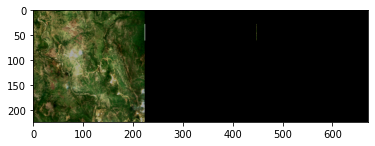

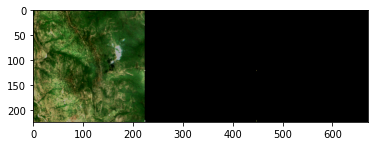

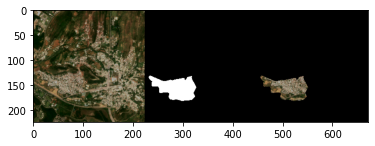

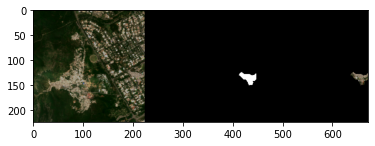

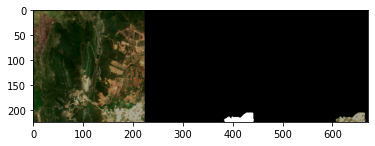

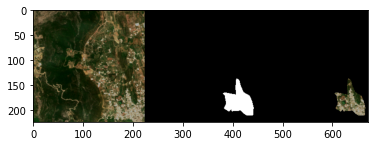

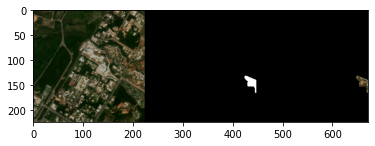

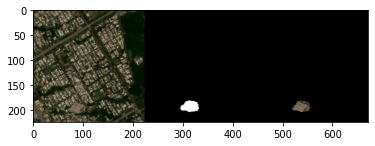

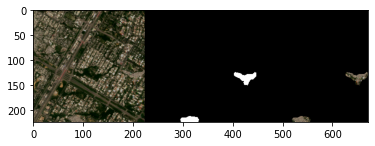

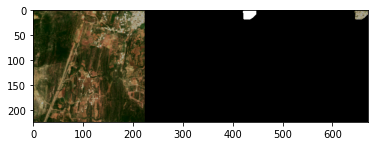

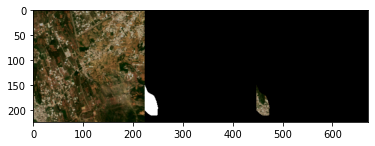

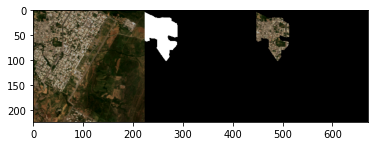

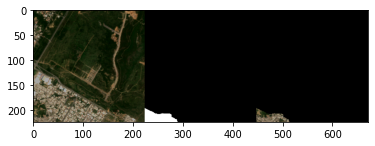

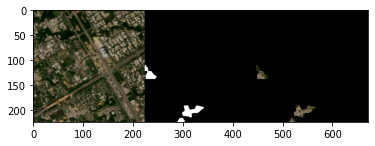

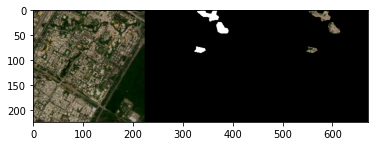

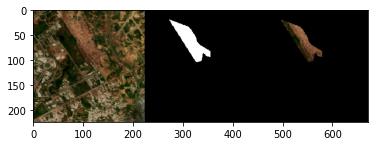

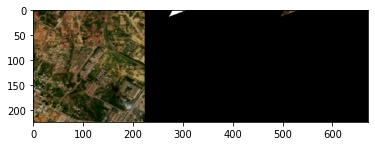

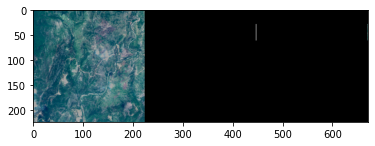

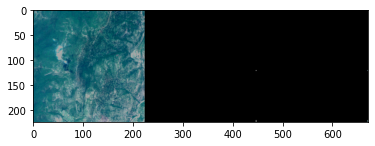

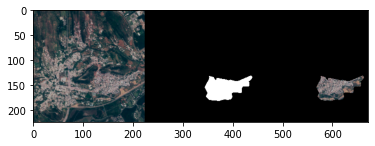

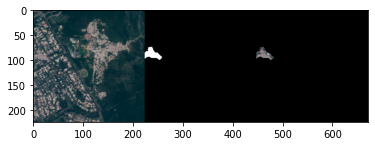

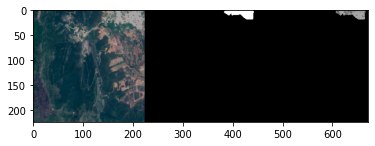

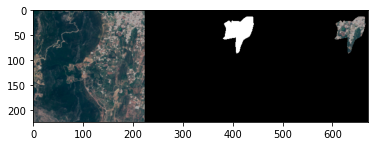

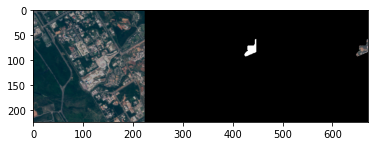

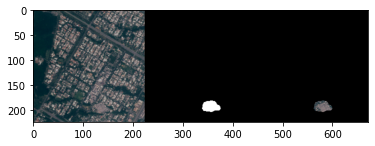

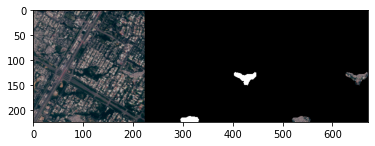

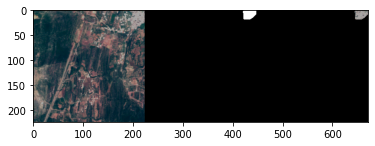

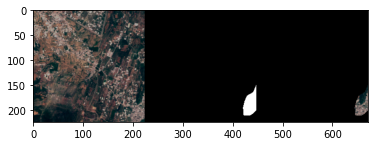

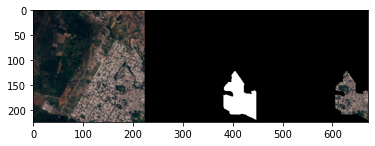

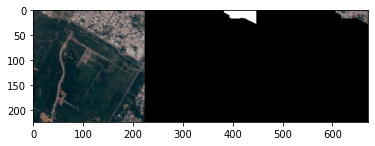

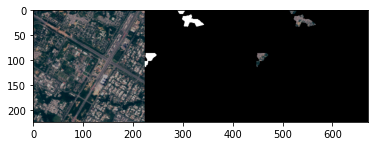

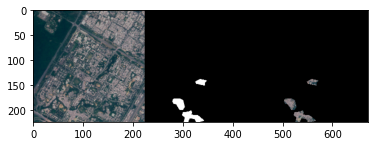

In [ ]:
slum_train_dataset = SlumDataset(train_input_paths,train_target_paths)
slum_test_dataset = SlumDataset(val_input_paths,val_target_paths)

for i in range(0,32):
  x,y = slum_train_dataset[i]
  showImage(x,y)

In [ ]:
# val_samples = 60

# slum_train_dataset = SlumDataset(input_img_paths[:-val_samples],target_img_paths[:-val_samples])
# slum_test_dataset = SlumDataset(input_img_paths[-val_samples:],target_img_paths[-val_samples:])

# for i in range(0,32):
#   x,y = slum_train_dataset[i]
#   showImage(x,y)

In [ ]:
batch_size = 8

In [ ]:
train_loader = DataLoader(slum_train_dataset, batch_size=batch_size,shuffle=True, num_workers=4)
test_loader = DataLoader(slum_test_dataset, batch_size=batch_size,shuffle=True, num_workers=4)

In [ ]:
train_set_size = len(train_loader) * batch_size
val_set_size = len(test_loader) * batch_size
train_pos_weight = 0
val_pos_weight = 0

print("Train Set :",train_set_size," Test Set: ",val_set_size)

Train Set : 176  Test Set:  72


In [ ]:
pos_values = []
for data,target in train_loader:
  pos_values.append(np.count_nonzero(target))

train_pos_weight = ((train_set_size * 50176) - sum(pos_values))/sum(pos_values)
print(train_pos_weight)

43.806819219645845


In [ ]:
pos_values = []
for data,target in test_loader:
  pos_values.append(np.count_nonzero(target))

val_pos_weight = ((val_set_size * 50176) - sum(pos_values))/sum(pos_values)
print(val_pos_weight)

36.632


In [ ]:
def showImageBatch(images,masks):
  for i in range(len(images)):
    fig = plt.figure()
    image = images[i]
    mask = masks[i]
    image = np.transpose(image.numpy(),(1,2,0))
    mask = np.transpose(mask.numpy(),(1,2,0))
    mask = np.concatenate((mask,)*3, axis=-1)
    combined = np.concatenate([image,mask,image * mask],axis=1)
    plt.imshow(combined)

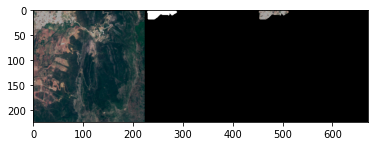

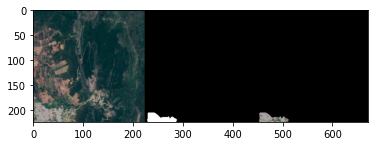

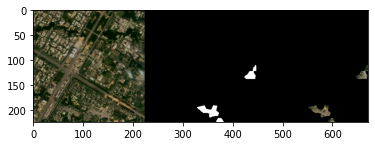

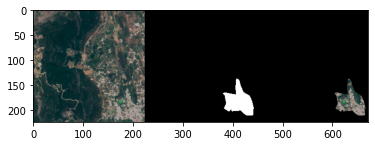

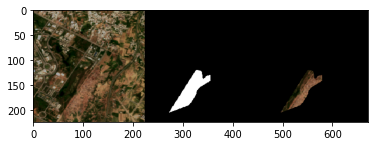

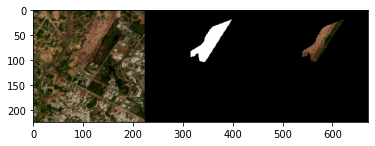

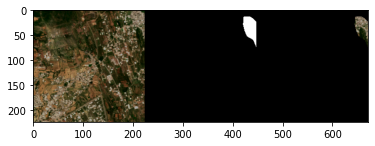

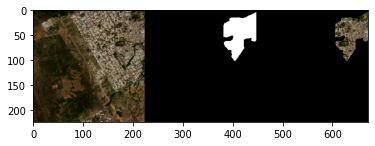

In [ ]:
batches = enumerate(train_loader)
i,batch = next(batches)
showImageBatch(batch[0],batch[1])

In [ ]:
smooth = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
  
  intersection = (outputs & labels).float().sum((1, 2))  
  union = (outputs | labels).float().sum((1, 2))        
  
  iou = (intersection + smooth) / (union + smooth)  
  
  thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
  
  return thresholded.mean()

In [ ]:
def dice_loss(pred, target):
    smooth = 1.

    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [ ]:
def train(model,model_name,loader,test_loader,criterion,threshold,epochs,optimizer,scheduler,path):
  for epoch in range(epochs):
    model.train()
    train_loss_epoch = []
    for batch_no, (x,y) in enumerate(loader):
      optimizer.zero_grad()
      output = model(x)
      if isinstance(output,dict):
        output = output['out']
      loss = criterion(output,y)
      loss.backward()
      train_loss_epoch.append(loss.item())
      optimizer.step()
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLearning Rate: {}'.format(
      epoch, batch_no * len(x), len(loader.dataset),
      100. * batch_no / len(loader), loss.item(),scheduler.get_last_lr()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_no*64) + ((epoch-1)*len(loader.dataset)))
    scheduler.step()
    diceLosses,IOU  = test(model,test_loader,threshold)
    print("Test Loss")
    print("DICE Score => ",torch.mean(diceLosses)," IOU => ",torch.mean(IOU))
    print('Avg Loss of {}: {}'.format(epoch,sum(train_loss_epoch)/160))
    drivePath = '{}project_transfer_{}_{}.pth'.format(path,model_name,epoch)
    torch.save(model.state_dict(), drivePath)

def test(model,loader,threshold,criterion):
  model.eval()
  diceLosses = []
  testLosses = []
  iou = []
  with torch.no_grad():
    for data, target in loader:
      output = model(data)
      if isinstance(output,dict):
        output = output['out']
      loss = criterion(output,target)
      testLosses.append(loss.item())
      output = torch.sigmoid(output)
      output = (output.numpy() > threshold).astype('uint8')
      output = torch.from_numpy(output)
      iou.append(iou_pytorch(output.int(), target.int()))
      diceLosses.append(dice_loss(output.int(),target.int()))
  return torch.tensor(diceLosses),torch.tensor(iou),torch.tensor(testLosses)

In [ ]:
def lr_find(model,loader,optimizer,scheduler,criterion):
  for batch_no, (x,y) in enumerate(loader):
    optimizer.zero_grad()
    output = model(x)
    if isinstance(output,dict):
        output = output['out']
    loss = criterion(output,y)
    lr_find_loss.append(loss.item())
    learning_rate.append(scheduler.get_last_lr())
    batch_count.append(batch_no)
    optimizer.step()
    scheduler.step()

In [ ]:
unet = smp.Unet("resnet101", encoder_weights="imagenet", classes=1, activation=None)
fcn_pytorch = models.segmentation.fcn_resnet50(pretrained=True)
fpn = smp.FPN('resnet101', in_channels=3,classes=1)
deepLabRes101 = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
maskRCNN = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
myModels = [unet,fcn_pytorch,fpn,deepLabRes101,maskRCNN]

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [78]:
i = 3
modelNames = ['unet','fcn_p','fpn','deepLab','maskRCNN']
modelName = modelNames[i]
currentModel = myModels[i]

In [79]:
currentModel

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [80]:

if modelName == 'fcn_p':
  currentModel.classifier[4]=nn.Sequential(
  nn.Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1)),
  nn.Conv2d(21, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  modelLR = 0.0009

elif modelName == 'unet':
  modelLR = 0.0003
elif modelName == 'deepLab':
  currentModel.classifier[4]=nn.Sequential(
  nn.Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1)),
  nn.Conv2d(21, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  modelLR = 0.0009
elif modelName == 'fpn':
  modelLR = 0.0003
elif modelName == 'maskRCNN':
  currentModel.roi_heads.mask_predictor.mask_fcn_logits = nn.Sequential(
  nn.Conv2d(256, 91, kernel_size=(1, 1), stride=(1, 1)),
  nn.Conv2d(91, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  nn.Conv2d(51, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )

In [81]:
currentModel

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
if modelName == 'maskRCNN':
  for count,parent in enumerate(currentModel.children()):
    if count==3:
        break
      
    for param in parent.parameters():
        param.requires_grad=False   

In [ ]:
for count,parent in enumerate(currentModel.children()):
  # if count==3:
  #     break   
     
  for param in parent.parameters():
      print(param.requires_grad)

1
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(

In [ ]:
learning_rate = []
lr_find_loss = []
batch_count = []

In [ ]:
optimizer_ft = torch.optim.Adam(currentModel.parameters(), lr=0.001,weight_decay=0.0001)

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.95)

lossFunc = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(train_pos_weight))

lr_find(currentModel,train_loader,optimizer_ft,exp_lr_scheduler,lossFunc)

Text(0.5, 0, 'Learning Rate')

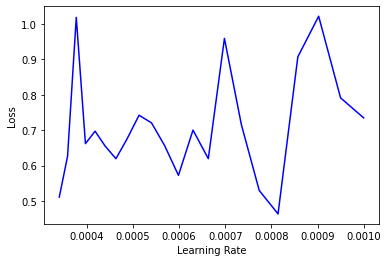

In [ ]:
fig = plt.figure()
plt.plot(learning_rate,lr_find_loss, color='blue')
plt.ylabel('Loss')
plt.xlabel('Learning Rate')

In [ ]:
for i in range(len(learning_rate)):
  print(learning_rate[i],lr_find_loss[i])

[0.001] 0.7347406148910522
[0.00095] 0.7911234498023987
[0.0009025] 1.0216920375823975
[0.000857375] 0.9069809317588806
[0.0008145062499999999] 0.4634426236152649
[0.0007737809374999998] 0.5295934677124023
[0.0007350918906249997] 0.7152994275093079
[0.0006983372960937497] 0.9591860175132751
[0.0006634204312890621] 0.6195261478424072
[0.000630249409724609] 0.7001057267189026
[0.0005987369392383785] 0.5723974108695984
[0.0005688000922764595] 0.6563910841941833
[0.0005403600876626365] 0.7205320596694946
[0.0005133420832795047] 0.7421852946281433
[0.00048767497911552944] 0.6760696172714233
[0.00046329123015975297] 0.6193850040435791
[0.0004401266686517653] 0.6546279191970825
[0.00041812033521917703] 0.697059154510498
[0.00039721431845821814] 0.6619393229484558
[0.0003773536025353072] 1.0185165405273438
[0.0003584859224085418] 0.6264643669128418
[0.0003405616262881147] 0.5109327435493469


In [ ]:
# for count,child in enumerate(currentModel.children()):
#     print(" Child ", count , "is -")
#     print(child)

In [82]:
rootPath = './drive/My Drive/Datasets/Project/modelCheckpoints/'
storedModels = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/modelCheckpoints/') if re.search('project_transfer_{}.*'.format(modelName),f.name)]
mtimes = {}

for i in range(len(storedModels)):
  filePath = '{}{}'.format(rootPath,storedModels[i])
  if os.path.exists(filePath):
    mtimes[i] = os.path.getmtime(filePath)
idx = None

if mtimes:
  idx = max(mtimes,key=mtimes.get)
  filePath = '{}{}'.format(rootPath,storedModels[idx])
  currentModel.load_state_dict(torch.load(filePath))

print(storedModels[idx])

project_transfer_deepLab_19.pth


In [ ]:
train_losses = []
train_counter = []

In [ ]:
epochs = 30

optimizer_ft = torch.optim.Adam(currentModel.parameters(), lr=modelLR,weight_decay=0.0001)

lossFunc = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(train_pos_weight))

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.95)

train(currentModel,modelName,train_loader,test_loader,lossFunc,0.75,epochs,optimizer_ft,exp_lr_scheduler,rootPath)

Train Epoch: 0 [0/170 (0%)]	Loss: 0.103409	Learning Rate: [0.0003]
Train Epoch: 0 [8/170 (5%)]	Loss: 2.852504	Learning Rate: [0.0003]
Train Epoch: 0 [16/170 (9%)]	Loss: 0.132335	Learning Rate: [0.0003]
Train Epoch: 0 [24/170 (14%)]	Loss: 0.079887	Learning Rate: [0.0003]
Train Epoch: 0 [32/170 (18%)]	Loss: 0.207968	Learning Rate: [0.0003]
Train Epoch: 0 [40/170 (23%)]	Loss: 0.289068	Learning Rate: [0.0003]
Train Epoch: 0 [48/170 (27%)]	Loss: 0.274466	Learning Rate: [0.0003]
Train Epoch: 0 [56/170 (32%)]	Loss: 0.188005	Learning Rate: [0.0003]
Train Epoch: 0 [64/170 (36%)]	Loss: 0.404004	Learning Rate: [0.0003]
Train Epoch: 0 [72/170 (41%)]	Loss: 0.176186	Learning Rate: [0.0003]
Train Epoch: 0 [80/170 (45%)]	Loss: 0.142641	Learning Rate: [0.0003]
Train Epoch: 0 [88/170 (50%)]	Loss: 0.176690	Learning Rate: [0.0003]
Train Epoch: 0 [96/170 (55%)]	Loss: 0.142211	Learning Rate: [0.0003]
Train Epoch: 0 [104/170 (59%)]	Loss: 0.152145	Learning Rate: [0.0003]
Train Epoch: 0 [112/170 (64%)]	Loss: 0

KeyboardInterrupt: ignored

Text(0, 0.5, 'negative log likelihood loss')

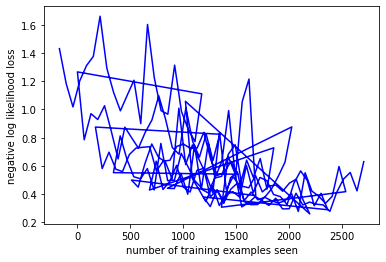

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
from statistics import mean 
lossFunc = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(val_pos_weight))
threshold = 0.5
print(modelName)
diceLosses,IOU,testLosses  = test(currentModel,test_loader,threshold,lossFunc)
print("DICE Score => ",torch.mean(diceLosses)," IOU => ",torch.mean(IOU)," BCE => ",torch.mean(testLosses))

fcn_p
DICE Score =>  tensor(0.4096)  IOU =>  tensor(0.5617)  BCE =>  tensor(2.9462)


In [63]:
def showPredictionBatch(images,targets,masks):
  for i in range(len(images)):
    fig = plt.figure(figsize=(15,15))
    image = images[i]
    target = targets[i]
    mask = masks[i]
    image = np.transpose(image.numpy(),(1,2,0))
    target = np.transpose(target.numpy(),(1,2,0))
    target = np.concatenate((target,)*3, axis=-1)
    mask = np.transpose(mask.numpy(),(1,2,0))
    mask = np.concatenate((mask,)*3, axis=-1)
    combined = np.concatenate([image,target,image * target,mask,image*mask],axis=1)
    plt.imshow(combined)

In [64]:
def predict(model,loader):
  model.eval()
  with torch.no_grad():
    for data, target in loader:
      output = model(data)

      if isinstance(output,dict):
        output = output['out']
      output = torch.sigmoid(output)
      output = (output.numpy() > 0.5).astype('uint8')
      target = target.numpy().astype('uint8')
      showPredictionBatch(data,torch.from_numpy(target),torch.from_numpy(output))
      break


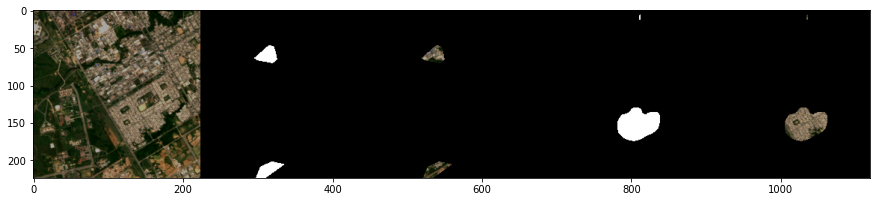

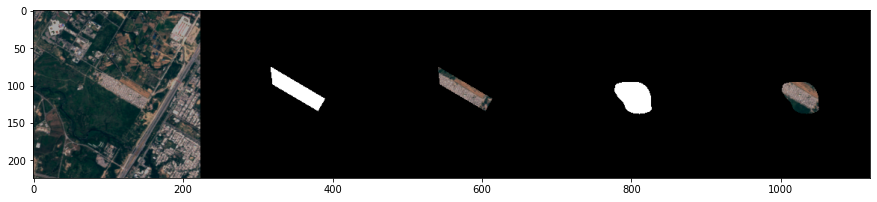

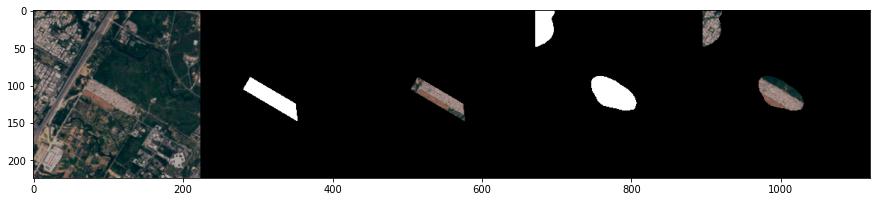

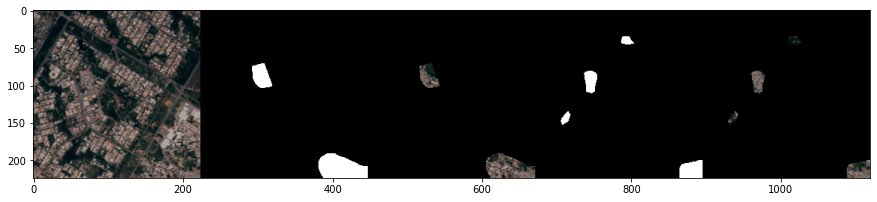

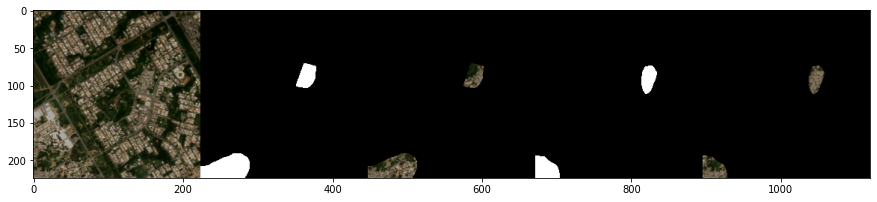

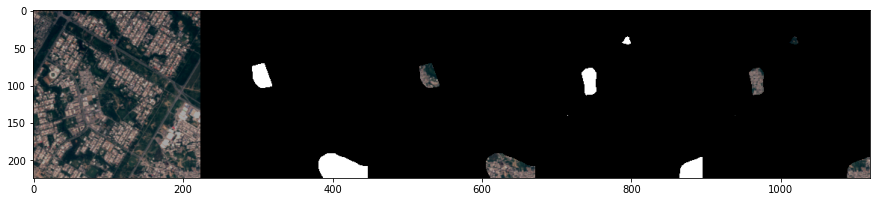

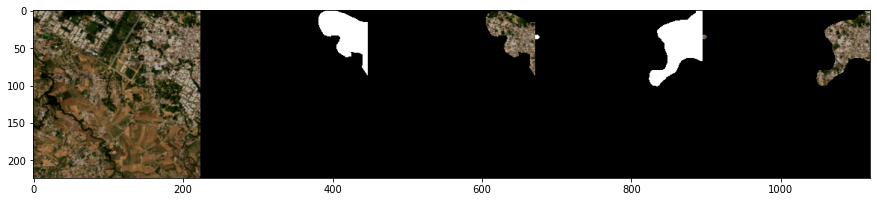

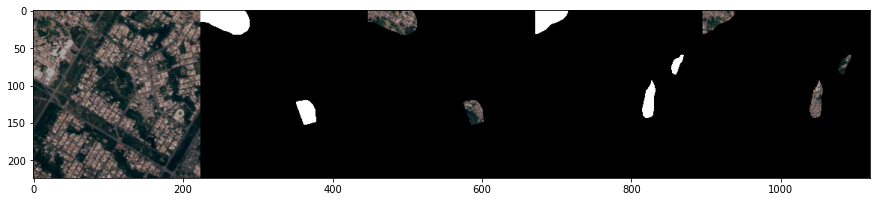

In [83]:
predict(currentModel,test_loader)